In [129]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12,8

# !pip install opencv-python-headless
import cv2
from matplotlib.patches import Rectangle
from typing import List, Tuple
import itertools
from copy import copy, deepcopy
import os
import shutil

import getpass
import azure.storage.blob
from azure.storage.blob import BlobClient, BlobServiceClient
from azure.core.exceptions import ResourceExistsError

In [47]:
####################################
# Read dataset
####################################

# import heat extremes data
fn = f"Ext_max_t__Rgn_1__2015__Abv_Avg_5_K_for_4_days__CMIP6_ssp245_Avg_yrs_1950_79.nc"
ds = xr.open_mfdataset(fn)

print(ds.attrs['Number of continuous days to be considered extreme'], "days")
print(ds.attrs['threshold'], "K above")

4 days
5 K above


In [130]:
# ds

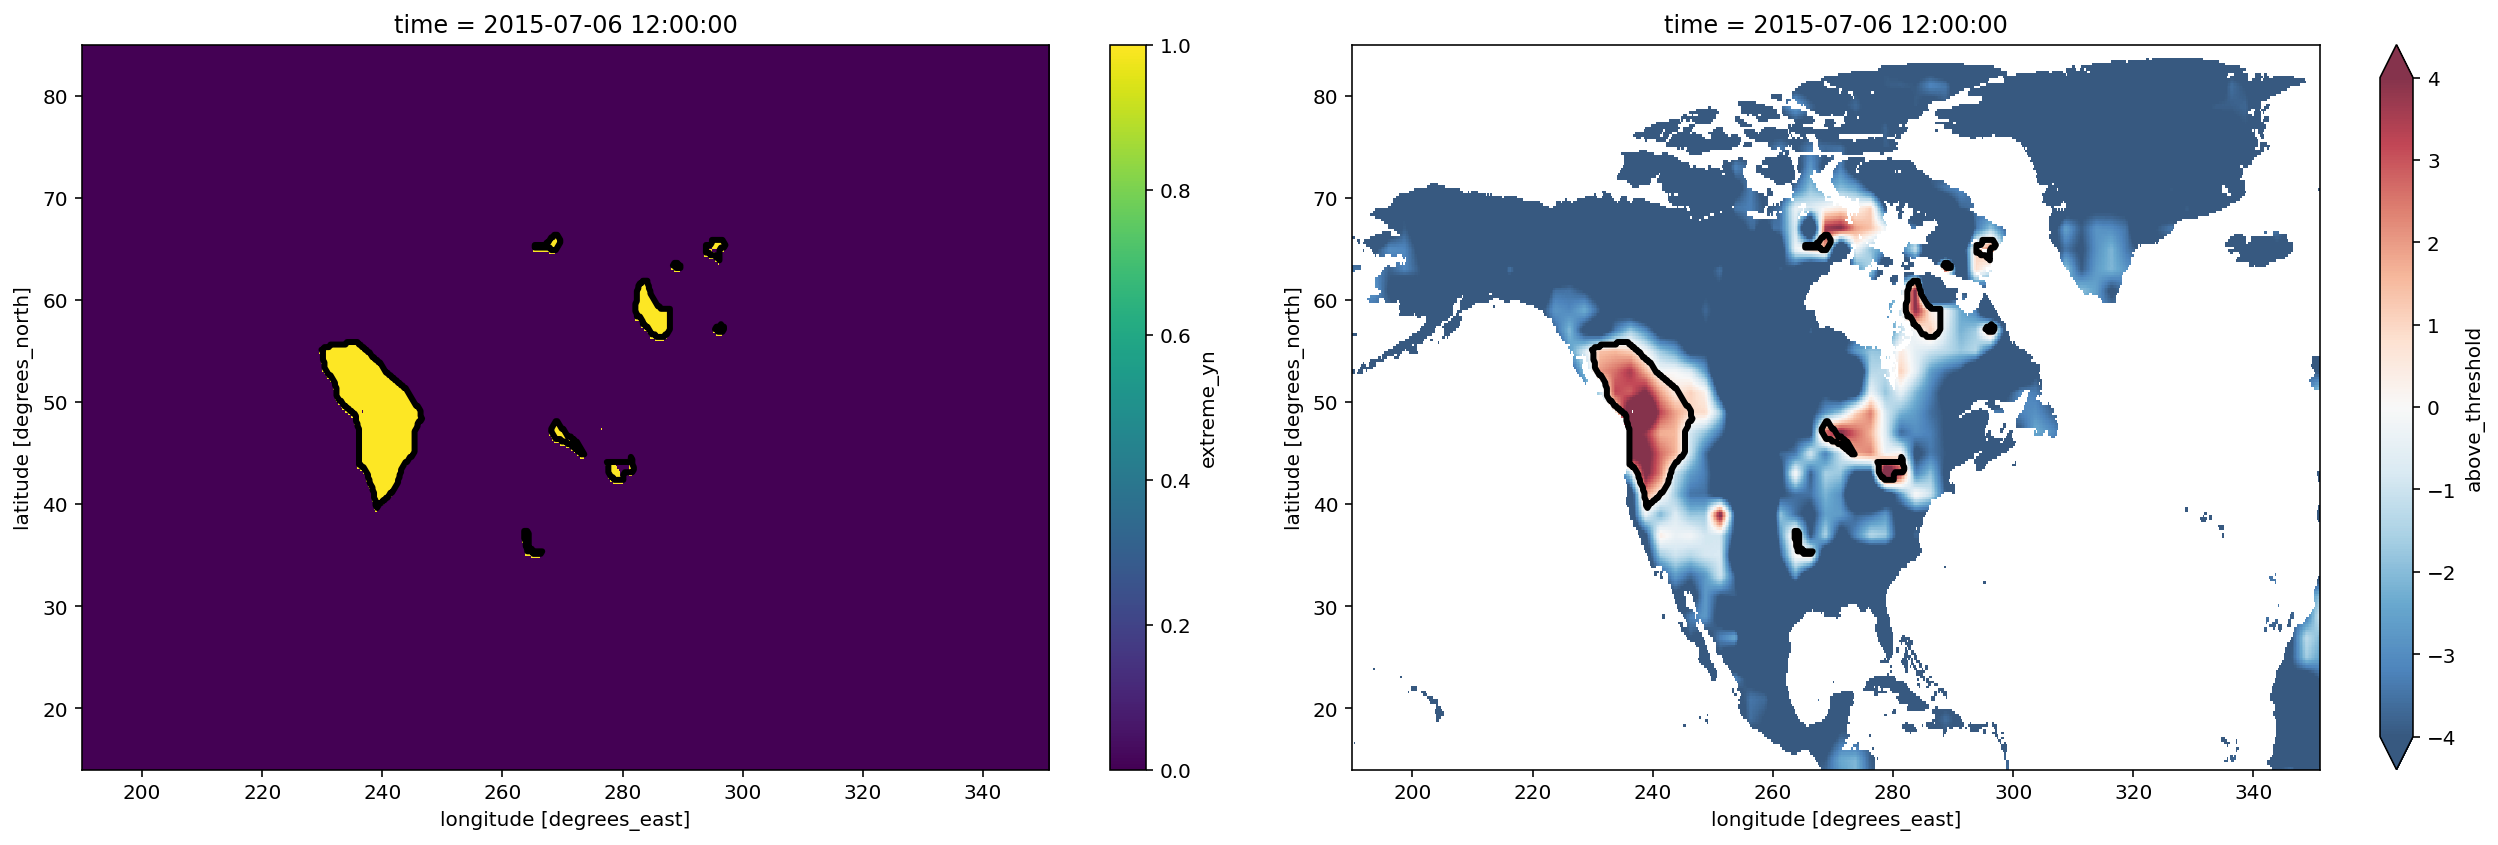

In [127]:
####################################
# NEW bounding-grids algotihm pipeline
####################################

"""
NEW, bounding-contours algorithm to find the extend of the heat events and
produce visualizations. It uses the the heat events y/n dataset 
which was (supposed to be pre-) produced by the "Heatwave Analysis" algorithm. 
"""

def as_latlon(single_contour: np.array, lon, lat) -> np.array:
    """Convert single contour indexes i,j to lon,lat"""
    assert single_contour.shape[1] == 2
    latlon = [(float(lon[x]), float(lat[y])) for (x,y) in single_contour]
    return np.array(latlon)

def draw_contours(arr2d: np.array) -> List[np.array]:
    """Encapsulates clusters of 1s and returns contours, [(i,j),(..),]."""
    H = arr2d.astype(np.uint8)
    ret, thresh = cv2.threshold(H, 0, 1, 0, cv2.THRESH_BINARY)

    kernel = np.ones((10,10), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours = [c.squeeze() for c in contours] # reduce dim to Nx2
    contours = [c for c in contours if c.ndim==2] # filter singletons

    return contours

####################################
# Visualize
####################################

# store some meta data for easy access
dr = pd.DatetimeIndex(ds['time'].dt.floor('D').values.astype('str'))
lon = ds.coords['lon']
lat = ds.coords['lat']
# lat_min, lat_max = ds['lat'].min(), ds['lat'].max()
# lon_min, lon_max = ds['lon'].min(), ds['lon'].max()

# create plot(s)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))

# select the day to plot
idx = 186

day = dr[idx].strftime("%Y-%m-%d")
tasmax = ds['tasmax'].sel(time=day)
tdiff = ds['above_threshold'].sel(time=day)
extreme = ds['extreme_yn'].sel(time=day)

im1 = extreme.squeeze().plot.imshow(ax=ax1)
im2 = tdiff.squeeze().plot.imshow(ax=ax2, cmap='RdBu_r', vmin=4, vmax=-4, alpha=0.8)

# find bounding contours
arr2d = extreme.values[0]
contours = draw_contours(arr2d) # as i,j
contours = [as_latlon(c, lon, lat) for c in contours] # i,j to lon,lat

# add these patches on the plot(s)
patches = [Polygon(c, True) for c in contours]
args = dict(edgecolors=("black",), linewidths=(3,), facecolor='none',)
p = PatchCollection(patches, **args)
ax1.add_collection(p)
p = PatchCollection(patches, **args)
ax2.add_collection(p)

fig.tight_layout()
        